In [1]:
import scanpy as sc
import pandas as pd 
import numpy as np
from anndata import AnnData
from muon import atac as ac

In [2]:
import jax.numpy as jnp

2023-01-04 14:32:30.962427: W external/org_tensorflow/tensorflow/tsl/platform/default/dso_loader.cc:66] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-04 14:32:31.012280: W external/org_tensorflow/tensorflow/tsl/platform/default/dso_loader.cc:66] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-04 14:32:31.014759: W external/org_tensorflow/tensorflow/tsl/platform/default/dso_loader.cc:66] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory


In [3]:
import cellrank as cr
import scvelo as scv

In [4]:
from moscot.problems.time import TemporalNeuralProblem

2023-01-04 14:32:32.565907: W external/org_tensorflow/tensorflow/tsl/platform/default/dso_loader.cc:66] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
2023-01-04 14:32:32.565939: W external/org_tensorflow/tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)


In [5]:
path = "/lustre/groups/ml01/workspace/moscot_paper/pancreas/pancreas_multiome_2022_processed.h5ad"

In [6]:
adata = sc.read(path)

In [7]:
adata.obs["time"] = adata.obs.apply(lambda x: 14.5 if x["sample"]=="E14.5" else 15.5, axis=1)

In [8]:
marginals = pd.read_csv("marginals.csv", index_col="Unnamed: 0")
adata.obs["a"] = marginals

In [9]:
adata = adata[:, adata.var["modality"]=="ATAC"].copy()

In [10]:
ac.pp.tfidf(adata, scale_factor=1e4)
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

In [11]:
ac.tl.lsi(adata, n_comps=30)

In [12]:
depth_corr = [np.corrcoef(adata.obsm["X_lsi"][:,i], adata.obs["nCount_ATAC"])[1,0] for i in range(adata.obsm["X_lsi"].shape[1])]

In [13]:
comps_to_remove = np.where(np.abs(depth_corr) > 0.4)[0]
comps_to_remove

array([0, 4])

In [14]:
subset = list(set(range(adata.obsm["X_lsi"].shape[1])) - set(comps_to_remove))

In [15]:
adata.obsm['X_lsi'] = adata.obsm['X_lsi'][:,subset]

In [16]:
tnp = TemporalNeuralProblem(adata)

In [17]:
adata

AnnData object with n_obs × n_vars = 16918 × 228259
    obs: 'n_counts', 'sample', 'n_genes', 'log_genes', 'mt_frac', 'rp_frac', 'ambi_frac', 'nCount_RNA', 'nFeature_RNA', 'nCount_ATAC', 'nFeature_ATAC', 'nucleosome_signal', 'nucleosome_percentile', 'TSS.enrichment', 'TSS.percentile', 'S_score', 'G2M_score', 'phase', 'proliferation', 'celltype', 'nCount_peaks', 'nFeature_peaks', 'time', 'a'
    var: 'modality'
    uns: 'celltype_colors', 'neighbors', 'log1p', 'lsi'
    obsm: 'X_pca', 'X_pca_wsnn', 'X_spca_wsnn', 'X_umap', 'X_umap_ATAC', 'X_umap_GEX', 'X_umap_wsnn', 'lsi_full', 'lsi_red', 'umap', 'umap_ATAC', 'umap_GEX', 'X_lsi'
    varm: 'LSI'
    obsp: 'connectivities', 'connectivities_wnn', 'distances', 'distances_wnn'

In [18]:
tnp = tnp.prepare("time", joint_attr="X_lsi", a="a")

In [19]:
tnp = tnp.solve(tau_a=0.95, tau_b=0.95)

INFO     Solving problem BirthDeathNeuralProblem[stage='prepared', shape=(9811, 7107)].                            


  0%|          | 0/25000 [00:00<?, ?it/s]

In [20]:
tnp

TemporalNeuralProblem[(14.5, 15.5)]

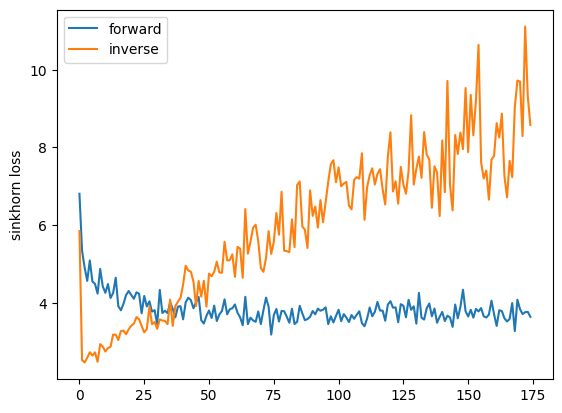

In [22]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.plot(tnp[14.5, 15.5].solution._training_logs["valid_logs"]["sinkhorn_loss_forward"], label="forward")
ax.plot(tnp[14.5, 15.5].solution._training_logs["valid_logs"]["sinkhorn_loss_inverse"], label="inverse")
ax.set_ylabel("sinkhorn loss")
ax.legend()
plt.show()

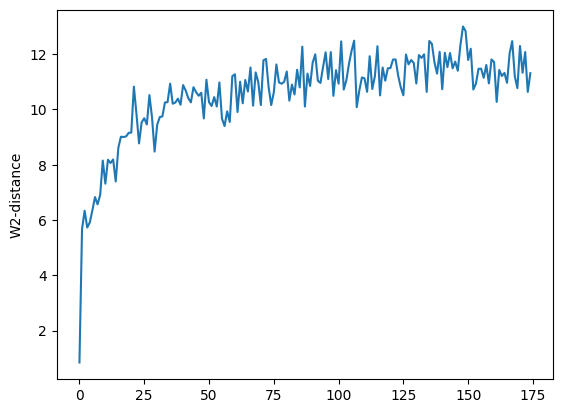

In [23]:
fig, ax = plt.subplots()
ax.plot(tnp[14.5, 15.5].solution._training_logs["valid_logs"]["valid_w_dist"])
ax.set_ylabel("W2-distance")
plt.show()

In [24]:
source = jnp.array(adata.obsm["X_lsi"].copy())

In [25]:
velocity = tnp[14.5, 15.5].solution.push(source) - source

In [26]:
adata_result = AnnData(shape=velocity.shape)
adata_result.obs = adata.obs.copy()

In [27]:
adata_result.layers["ATAC_velocity"] = np.asarray(velocity)
adata_result.layers["X_lsi"] = np.asarray(adata.obsm["X_lsi"])

In [28]:
adata_result

AnnData object with n_obs × n_vars = 16918 × 28
    obs: 'n_counts', 'sample', 'n_genes', 'log_genes', 'mt_frac', 'rp_frac', 'ambi_frac', 'nCount_RNA', 'nFeature_RNA', 'nCount_ATAC', 'nFeature_ATAC', 'nucleosome_signal', 'nucleosome_percentile', 'TSS.enrichment', 'TSS.percentile', 'S_score', 'G2M_score', 'phase', 'proliferation', 'celltype', 'nCount_peaks', 'nFeature_peaks', 'time', 'a'
    layers: 'ATAC_velocity', 'X_lsi'

In [29]:
adata_result.write("/lustre/groups/ml01/workspace/monge_velo/multiome_pancreas/adata_atac_velocities.h5ad")